In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from libfmtviz.bits import Bits
from libfmtviz.range_fmt import RangeFormat, RangeFormatStats, ByteOffset
from libfmtviz.util import *
from typing import *
from dataclasses import dataclass

In [2]:
# TODO some way to display RangeFormat with flexbox CSS

In [3]:
@dataclass
class LinearEncoding:
    bit_width: int
    # All integer linear encodings f(x) -> y can be expressed as f(x) = x * a + b
    # We choose to assume shifts everywhere -> x << a_log2 + b
    a_log2: int
    b: int
    
    def __init__(self, bit_width: int, a_log2: int, b: int):
        self.bit_width = bit_width
        self.a_log2 = a_log2
        self.b = b
    
    @property
    def min(self):
        return self.b

    @property
    def max_incl(self):
        return (((2 ** self.bit_width) - 1) << self.a_log2) + self.b

    def __len__(self):
        return (2 ** self.bit_width) << self.a_log2

    def decode(self, enc_value: int) -> int:
        assert 0 <= enc_value and enc_value < (2 ** self.bit_width)
        return (enc_value << self.a_log2) + self.b
        
    def encode(self, value: int) -> Optional[int]:
        if (value - self.b) % (2 ** self.a_log2) != 0:
            return None
        enc_value = (value - self.b) >> self.a_log2
        if (enc_value >> self.bit_width) != 0:
            return None
        return enc_value

    def as_bits(self, name: str) -> Bits:
        return Bits(name, self.bit_width)
    
    @classmethod
    def id(cls, bit_width: int):
        return LinearEncoding(bit_width, a_log2=0, b=0)
    
    @classmethod
    def offset(cls, bit_width: int, offset: int):
        return LinearEncoding(bit_width=bit_width, a_log2=0, b=offset)

    @classmethod
    def shifted_left(cls, bit_width: int, shift: int):
        return LinearEncoding(bit_width=bit_width, a_log2=shift, b=0)

In [4]:
@dataclass
class ArrayOfElemRangeFormat(RangeFormat):
    _addrspace_width: int # 48 or 64
    base_enc: LinearEncoding
    exponent_enc: LinearEncoding
    count_enc: LinearEncoding # Implicit count top bit is impossible.

    def __init__(self, addrspace_width: int, base_align: int, count_enc: LinearEncoding, exponent_enc: LinearEncoding):
        self._addrspace_width = addrspace_width
        self.base_enc = LinearEncoding.shifted_left(bit_width=addrspace_width - base_align, shift=base_align)
        self.count_enc = count_enc
        self.exponent_enc = exponent_enc

    @property
    def addrspace_width(self) -> int:
        return self._addrspace_width
    
    def format_bits(self) -> Sequence[Bits]:
        return [
            Bits("E", self.exponent_enc.bit_width),
            Bits("C", self.count_enc.bit_width),
            Bits("B", self.base_enc.bit_width),
        ]

    @property
    def min_length(self) -> int:
        return 2 ** self.exponent_enc.min

    def get_stats_for_length(self, length: int) -> Optional[RangeFormatStats]:

        # We cannot use implicit top bit of Count based on the value of Exponent.
        # It creates a pow2 "jump" between Exponent=min and Exponent=min+1.
        # CHERI gets away with it because it uses a separate bit to toggle it. Effectively I_E is actually the top bit of Length (sort of) and you can still encode a 0-exponent in T_E and B_E to avoid the pow2 jump.
        #
        # # Are we within the minimum exponent:
        # # We can be if length[MSB:min_exp] fits into self.count_enc
        # # i.e. self.count_enc.bit_width >= MSB-min_exp
        # # consider length = 0b111111 | 0'12, exponent_enc.min=12, self.count_enc.bit_width=6. This is the breaking point.
        # # MSB=17, bits that count needs to encode = MSB-12+1=6
        # at_min_exponent = (msb_of(length) - self.exponent_enc.min + 1) <= self.count_enc.bit_width
        # if at_min_exponent:
        #     # The maximum INCLUSIVE length representable is (count = all 1s) * 2^min_exp
        #     length_max = ((2**self.count_enc.bit_width) - 1) * (2**self.exponent_enc.min)
        #     # But for exclusive length
        #     return RangeFormatStats(
        #         length_min=2 ** self.exponent_enc.min,
        #         length_max_excl=length_max+1,
                
        #         min_base_align_bits=self.base_enc.a_log2,
        #         min_length_align_bits=self.exponent_enc.min,
        #     )
        # else:
        #     if implicit_count_top:
        #         # Select minimum exponent relative to the TOP bit.
        #         # If MSB = 
        #         exp = min(msb_of(length) - self.count_enc.bit_width, self.exponent_enc.max_incl)

            
        #     else:
        #         pass
                
        # If lsb_of(length) is within the range of exponent_enc, that's fine. If it's too big, that's also fine! Use the maximum exponent and hope the count has enough bits
        exp = min(lsb_of(length), self.exponent_enc.max_incl)
        if self.exponent_enc.encode(exp) is None:
            # Must be too small
            print(f"can't encode exp={exp} with {self.exponent_enc}. max_incl: {self.exponent_enc.max_incl}")
            return None
    
        count = (length >> exp - 1)
        if self.count_enc.encode(count) is None:
            print(f"need count = 0x{count:x} to represent length {ByteOffset(length)} with exp {exp} which can't be represented with {self.count_enc}")
            return None
        return RangeFormatStats(
            length_min=2 ** exp,
            length_max_excl=(2**(exp + self.count_enc.bit_width - 1 + self.count_enc.a_log2)),
            
            min_base_align_bits=self.base_enc.a_log2,
            min_length_align_bits=exp,
        )

In [5]:
# Note: somewhat annoyingly this allows count=0.
array_48addr_base6 = ArrayOfElemRangeFormat(addrspace_width=48, base_align=6, exponent_enc=LinearEncoding.offset(bit_width=5, offset=6), count_enc=LinearEncoding.id(17))

array_64addr_base12 = ArrayOfElemRangeFormat(addrspace_width=64, base_align=12, exponent_enc=LinearEncoding.offset(bit_width=6, offset=12), count_enc=LinearEncoding.id(6))

need count = 0x20000 to represent length 8.0PiB with exp 37 which can't be represented with LinearEncoding(bit_width=17, a_log2=0, b=0)


,length min,length max (excl),base align,length align
0,64.0B,4.0MiB,64.0B,64.0B
1,4.0MiB,8.0MiB,64.0B,128.0B
2,8.0MiB,16.0MiB,64.0B,256.0B
3,16.0MiB,32.0MiB,64.0B,512.0B
4,32.0MiB,64.0MiB,64.0B,1.0KiB
5,64.0MiB,128.0MiB,64.0B,2.0KiB
6,128.0MiB,256.0MiB,64.0B,4.0KiB
7,256.0MiB,512.0MiB,64.0B,8.0KiB
8,512.0MiB,1.0GiB,64.0B,16.0KiB
9,1.0GiB,2.0GiB,64.0B,32.0KiB


64

need count = 0x20000 to represent length 8.0PiB with exp 37 which can't be represented with LinearEncoding(bit_width=17, a_log2=0, b=0)


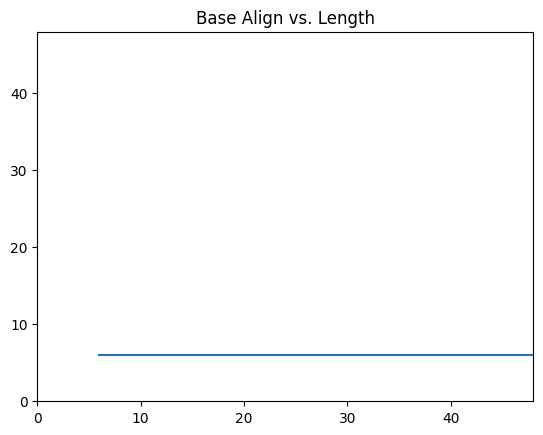

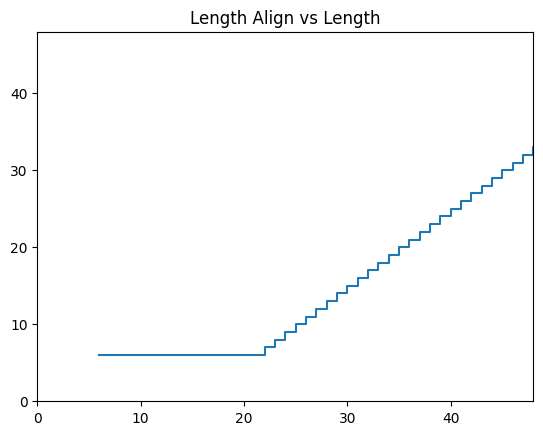

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)


,length min,length max (excl),base align,length align
0,4.0KiB,128.0KiB,4.0KiB,4.0KiB
1,128.0KiB,256.0KiB,4.0KiB,8.0KiB
2,256.0KiB,512.0KiB,4.0KiB,16.0KiB
3,512.0KiB,1.0MiB,4.0KiB,32.0KiB
4,1.0MiB,2.0MiB,4.0KiB,64.0KiB
...,...,...,...,...
59,32768.0EiB,65536.0EiB,4.0KiB,2048.0EiB
60,65536.0EiB,131072.0EiB,4.0KiB,4096.0EiB
61,131072.0EiB,262144.0EiB,4.0KiB,8192.0EiB
62,262144.0EiB,524288.0EiB,4.0KiB,16384.0EiB


64

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)


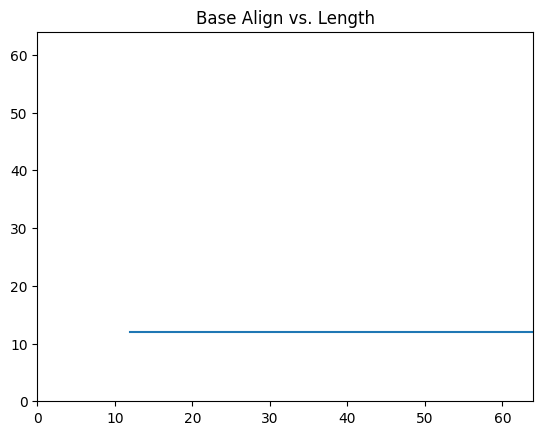

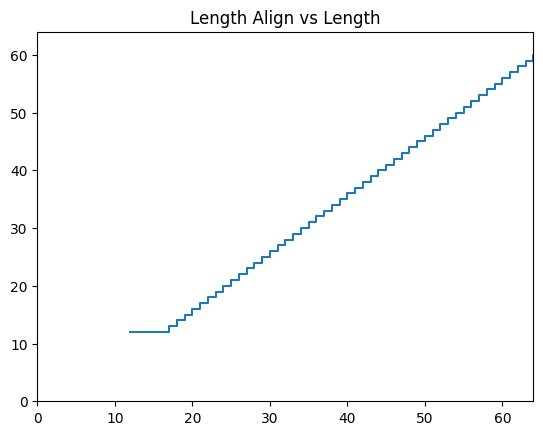

In [6]:
def display_ranges(r: RangeFormat) -> Generator[Tuple[ByteOffset, ByteOffset, ByteOffset, ByteOffset], None, None]:
    start = r.min_length
    for range_stats in r.generate_stats():
        if range_stats.length_max_excl > start:
            yield (ByteOffset(start), ByteOffset(range_stats.length_max_excl), ByteOffset(1 << range_stats.min_base_align_bits), ByteOffset(1 << range_stats.min_length_align_bits))
        start = range_stats.length_max_excl

def table_range(r: RangeFormat):
    display(pd.DataFrame(display_ranges(r), columns=["length min", "length max (excl)", "base align", "length align"]))

def get_range_plot_dots(r: RangeFormat):
    xs = []
    ys_base_align = []
    ys_length_align = []
    for (length_min, length_max_excl, base_align_bits, length_align_bits) in display_ranges(r):
        xs.append(lsb_of(length_min.offset))
        xs.append(lsb_of(length_max_excl.offset))
        ys_base_align.append(lsb_of(base_align_bits.offset))
        ys_base_align.append(lsb_of(base_align_bits.offset))
        ys_length_align.append(lsb_of(length_align_bits.offset))
        ys_length_align.append(lsb_of(length_align_bits.offset))
    return xs, ys_base_align, ys_length_align

def plot_ranges(title: str, r: RangeFormat):
    xs, ys_base_align, ys_length_align = get_range_plot_dots(r)

    fig, ax1 = plt.subplots(1)
    ax1.plot(xs, ys_base_align)
    ax1.set_xlim([0, r.addrspace_width])
    ax1.set_ylim([0, r.addrspace_width])
    ax1.set_title("Base Align vs. Length")
    fig, ax2 = plt.subplots(1)
    ax2.plot(xs, ys_length_align)
    ax2.set_title("Length Align vs Length")
    ax2.set_xlim([0, r.addrspace_width])
    ax2.set_ylim([0, r.addrspace_width])
    plt.show()

display(pd.DataFrame(display_ranges(array_48addr_base6), columns=["length min", "length max (excl)", "base align", "length align"]))
display(sum(x.bitlen() for x in array_48addr_base6.format_bits()))
plot_ranges("48bit addr space, 6bit base align", array_48addr_base6)

display(pd.DataFrame(display_ranges(array_64addr_base12), columns=["length min", "length max (excl)", "base align", "length align"]))
display(sum(x.bitlen() for x in array_64addr_base12.format_bits()))
plot_ranges("64bit addr space, 12bit base align", array_64addr_base12)


need count = 0x1ffffff to represent length 32.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=24, a_log2=0, b=0)


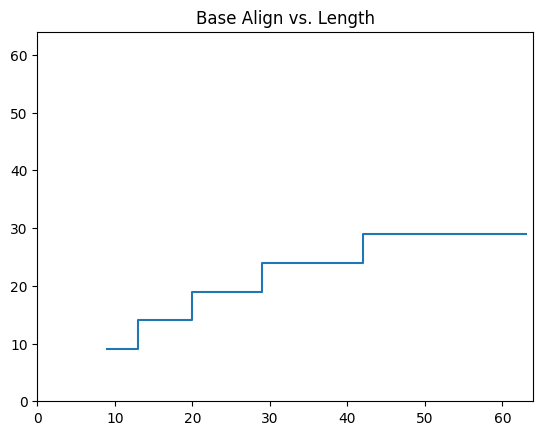

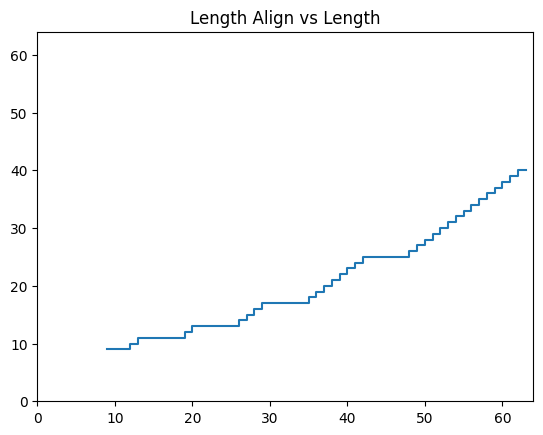

In [7]:
class DynamicRangeShift(RangeFormat):
    exponent_enc: LinearEncoding
    exponent_range_to_count: Dict[Tuple[int,int],int]
    total_bit_width: int = 64

    
    # This variable controls whether the get_stats_for_length() function tries to minimize the exponent.
    # This is unnecessary when plotting or displaying results, because display_ranges() always picks the minimum exponent for a given length range anyway.
    optimize_for_base: bool = False

    def __init__(self, exponent_enc: LinearEncoding, exponent_range_to_count: Dict[Tuple[int,int],int], total_bit_width=64, optimize_for_base=False):
        self.optimize_for_base = optimize_for_base
        self.exponent_enc = exponent_enc
        self.exponent_range_to_count = exponent_range_to_count
        self.total_bit_width = total_bit_width
    
    @property
    def addrspace_width(self) -> int:
        return 64

    def format_bits(self) -> Sequence[Bits]:
        return [
            Bits("E", self.exponent_enc.bit_width),
            Bits("B | C", self.total_bit_width-self.exponent_enc.bit_width),
        ]

    @property
    def min_length(self) -> int:
        return 2 ** self.exponent_enc.min

    def exp_for_length(self, length: int) -> int:
        # Figure out the exponent for this length.
        if self.optimize_for_base:
            # We want to target the smallest possible exponent that can represent the value, so we get the maximum base addr precision.
            # In theory, one could also take the base addr into account here to only use the precision we need, but we're going to leave that for now.
            msb = msb_of(length)
            assert msb >= self.exponent_enc.min

            # Trying to solve the recursive equation 
            # EXP = MSB - COUNT'(EXP) + 1
            # Explanation: If this were a flat format, we would be trying to get EXP = MSB - COUNT' + 1. This implies the actual length would be (minimal exponent) * (maximum count) (NOTE REMOVE THE MINUS 1 TERM IF WE USE IMPLICIT TOP BIT OF COUNT).
            # But COUNT' is now dependent on EXP, based on the following LUT:
            # {
            #   EXP in [9,10] => COUNT' = 4,
            #   EXP in [11,12] => COUNT' = 9,
            #   EXP in [13,16] => COUNT' = 14,
            #   EXP in [17,24] => COUNT' = 19,
            #   EXP in [25,40] => COUNT' = 24,
            # }
            # the maximum value representable by EXP in [9,10] is 2^14, so if MSB < 14 then use 9 or 10.
            # otherwise if MSB-9 <= 12, (14 < MSB <= 21) then  use [11, 12], etc.
            # selecting the minimum value of an EXP in [X, Y] has to be done brute-force 
            # IF YOU USE THIS IN HARDWARE JUST USE A LUT OK???

            for (min_exp, max_exp_incl), count_w in self.exponent_range_to_count.items():
                if (msb - count) < max_exp_incl:
                    return max(min_exp, msb - count + 1)
            return None

            # possible_exps = [
            #     msb - 4,
            #     msb - 9,
            #     msb - 14,
            #     msb - 19,
            #     msb - 24
            # ]
            # REQ_ENC_EXP_RANGES = [
            #     (0, 1),
            #     (2, 3),
            #     (4, 7),
            #     (8, 15),
            #     (16, 31),
            # ] 

            # return min(
            #     exp
            #     for exp, enc_range in zip(possible_exps, REQ_ENC_EXP_RANGES)
            #     if enc_range[0] <= exp - self.exponent_enc.min and exp - self.exponent_enc.min <= enc_range[1]
            # )  
        else:
            # We want to target the smallest possible exponent
            # If lsb_of(length) is within the range of exponent_enc, that's fine. If it's too big, that's also fine! Use the maximum exponent and hope the count has enough bits.
            return min(lsb_of(length), self.exponent_enc.max_incl)
        
    def base_and_count_enc_for_exp(self, exp: int) -> Tuple[LinearEncoding, LinearEncoding]:
        count_w = None
        for (min_exp, max_exp_incl), count_w in self.exponent_range_to_count.items():
            if min_exp <= exp and exp <= max_exp_incl:
                break
        assert count_w is not None

        base_w = self.total_bit_width-self.exponent_enc.bit_width-count_w
        base_align = 64-base_w
        
        return LinearEncoding.shifted_left(bit_width=base_w, shift=base_align), LinearEncoding.id(count_w)

    def get_stats_for_length(self, length: int) -> Optional[RangeFormatStats]:
        # Figure out the exponent for this length
        exp = self.exp_for_length(length)
        if exp is None or self.exponent_enc.encode(exp) is None:
            print(f"can't encode exp={exp} with {self.exponent_enc}. max_incl: {self.exponent_enc.max_incl}")
            return None
        
        count = (length >> exp) - 1
        base_enc, count_enc = self.base_and_count_enc_for_exp(exp)
        
        if count_enc.encode(count) is None:
            print(f"need count = 0x{count:x} to represent length {ByteOffset(length)} with exp {exp} which can't be represented with {count_enc}")
            return None
        return RangeFormatStats(
            length_min=2 ** exp,
            length_max_excl=(2**(exp + count_enc.bit_width - 1 + count_enc.a_log2)),
            
            min_base_align_bits=base_enc.a_log2,
            min_length_align_bits=exp,
        )

dynamic_shift = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=5, a_log2=0, b=9),
    exponent_range_to_count={
        (9, 10): 4,
        (11, 12): 9,
        (13, 16): 14,
        (17, 24): 19,
        (25, 40): 24,
    }
)
plot_ranges("dynamic", dynamic_shift)

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)
need count = 0x1ffffff to represent length 32.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=24, a_log2=0, b=0)


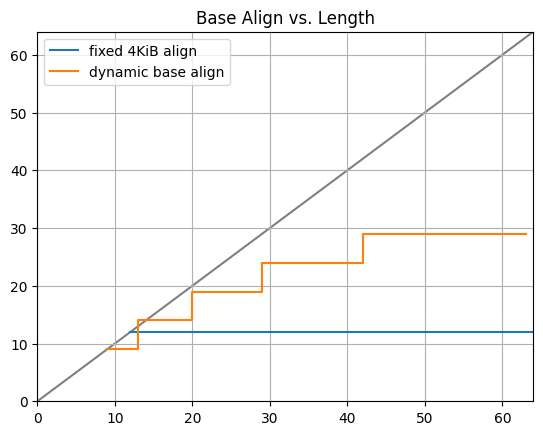

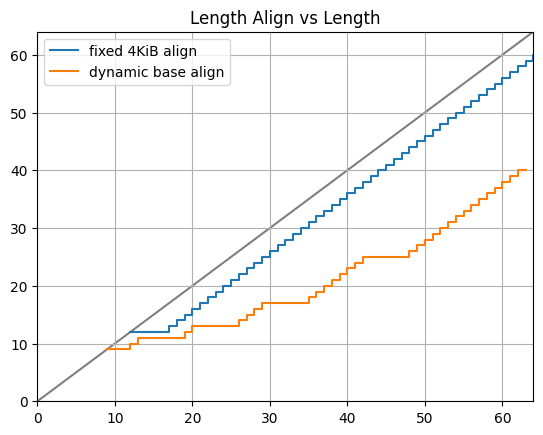

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)


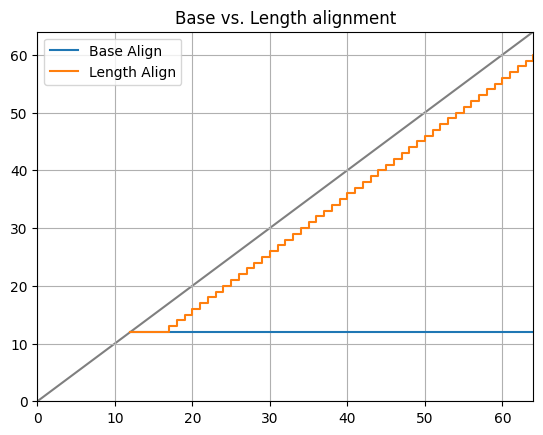

need count = 0x1ffffff to represent length 32.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=24, a_log2=0, b=0)


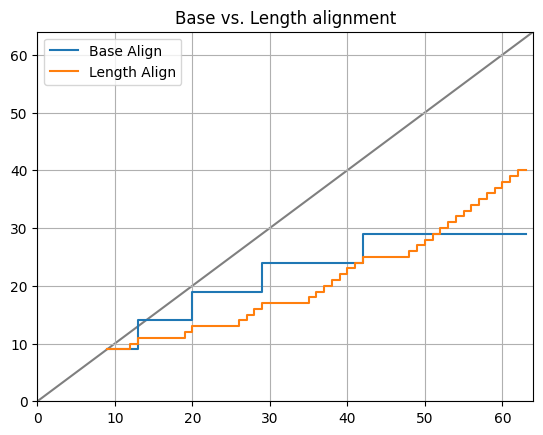

In [8]:
def compare_align_plots(rs: Sequence[Tuple[str, RangeFormat]]):
    fig, base_ax = plt.subplots(1)
    fig, len_ax = plt.subplots(1)

    for name, r in rs:
        xs, ys_base_align, ys_length_align = get_range_plot_dots(r)
    
        base_ax.plot(xs, ys_base_align, label=name)
        len_ax.plot(xs, ys_length_align, label=name)

    base_ax.set_xlim([0, r.addrspace_width])
    base_ax.set_ylim([0, r.addrspace_width])
    base_ax.set_title("Base Align vs. Length")
    lims = [
        0,
        np.max([base_ax.get_xlim(), base_ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    base_ax.plot(lims, [x for x in lims], 'k-', alpha=0.5, zorder=0)
    base_ax.grid()
    base_ax.legend()
    len_ax.set_title("Length Align vs Length")
    len_ax.set_xlim([0, r.addrspace_width])
    len_ax.set_ylim([0, r.addrspace_width])
    lims = [
        0,
        np.max([len_ax.get_xlim(), len_ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    len_ax.plot(lims, [x for x in lims], 'k-', alpha=0.5, zorder=0)
    len_ax.grid()
    len_ax.legend()
    plt.show()

def compare_base_length_align(r: RangeFormat):
    fig, ax = plt.subplots(1)

    xs, ys_base_align, ys_length_align = get_range_plot_dots(r)

    ax.set_title("Base vs. Length alignment")
    ax.plot(xs, ys_base_align, label="Base Align")
    ax.plot(xs, ys_length_align, label="Length Align")
    ax.set_xlim([0, r.addrspace_width])
    ax.set_ylim([0, r.addrspace_width])
    lims = [
        0,
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, [x for x in lims], 'k-', alpha=0.5, zorder=0)
    ax.grid()
    ax.legend()
    plt.show()


compare_align_plots([
    ("fixed 4KiB align", array_64addr_base12),
    ("dynamic base align", dynamic_shift),
])
compare_base_length_align(array_64addr_base12)
compare_base_length_align(dynamic_shift)

need count = 0x1ffffff to represent length 32.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=24, a_log2=0, b=0)


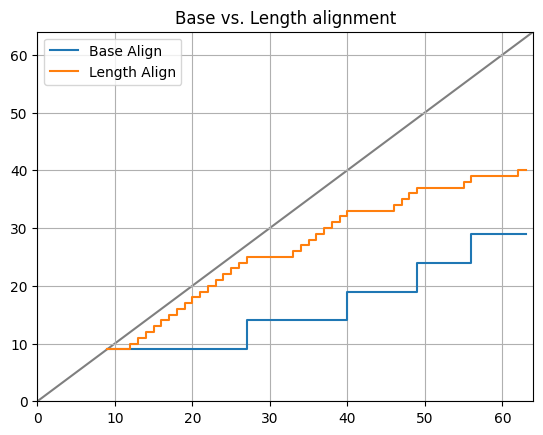

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)
need count = 0x1ffffff to represent length 32.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=24, a_log2=0, b=0)
need count = 0x3ffffff to represent length 64.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=25, a_log2=0, b=0)


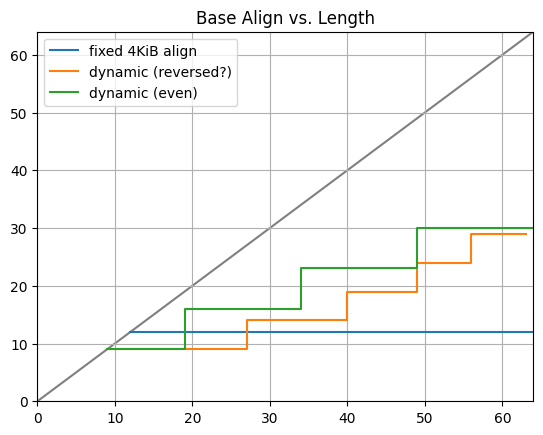

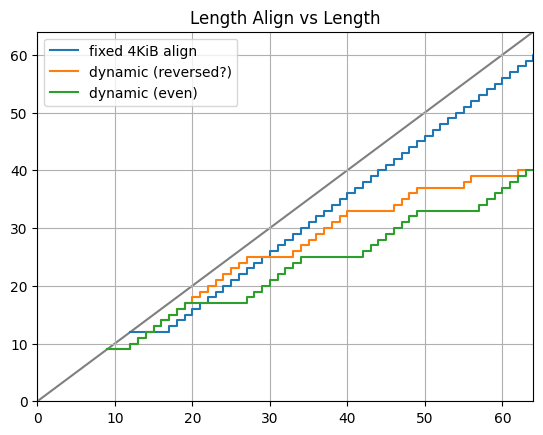

need count = 0x3ffffff to represent length 64.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=25, a_log2=0, b=0)


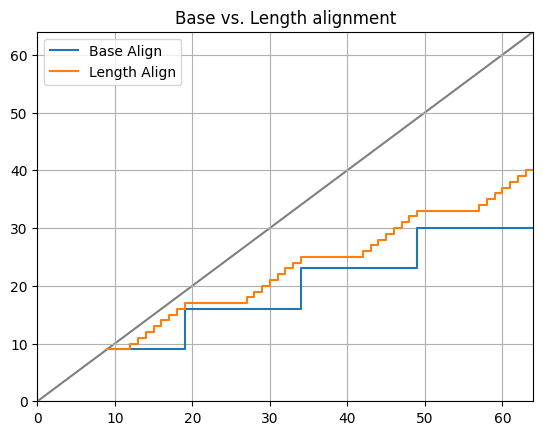

need count = 0x3ffffff to represent length 64.0EiB with exp 40 which can't be represented with LinearEncoding(bit_width=25, a_log2=0, b=0)


,length min,length max (excl),base align,length align
0,512.0B,4.0KiB,512.0B,512.0B
1,4.0KiB,8.0KiB,512.0B,1.0KiB
2,8.0KiB,16.0KiB,512.0B,2.0KiB
3,16.0KiB,32.0KiB,512.0B,4.0KiB
4,32.0KiB,64.0KiB,512.0B,8.0KiB
5,64.0KiB,128.0KiB,512.0B,16.0KiB
6,128.0KiB,256.0KiB,512.0B,32.0KiB
7,256.0KiB,512.0KiB,512.0B,64.0KiB
8,512.0KiB,128.0MiB,64.0KiB,128.0KiB
9,128.0MiB,256.0MiB,64.0KiB,256.0KiB


In [9]:
# Oh dear. Base align > length align implies a lot of those lengths are not fully used.
# Also if you don't have implicit top bit then things go pear shaped.
# If we do this, (ignoring top bit fiascos) we effectively do (is this bit set? no, is next bit set? no, ...) for our range-to-count LUT still, but just on (32 - exp)
dynamic_shift_retry = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=5, a_log2=0, b=9),
    exponent_range_to_count={
        (9, 24): 4,
        (25, 32): 9,
        (33, 36): 14,
        (37, 38): 19,
        (39, 40): 24,
    }
)
compare_base_length_align(dynamic_shift_retry)

# Finally, one might just say "evenly space out the jumps please"
# Conveniently, this allows us to represent 2^64 without an implicit top bit.
dynamic_shift_even = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=5, a_log2=0, b=9),
    exponent_range_to_count={
        (9, 16):   4, # B'_min = 64 - 9 = 55, C'min = 64 - B'min - E' = 64 - 55 - 5 = 4
        (17, 24): 11,
        (25, 32): 18,
        (33, 40): 25,
    }
)
compare_align_plots([
    ("fixed 4KiB align", array_64addr_base12),
    ("dynamic (reversed?)", dynamic_shift_retry),
    ("dynamic (even)", dynamic_shift_even),
])
compare_base_length_align(dynamic_shift_even)
table_range(dynamic_shift_even)
# THOUGHT: we might want to optimize for minimum alignment <2^40,

need count = 0x40 to represent length 1048576.0EiB with exp 75 which can't be represented with LinearEncoding(bit_width=6, a_log2=0, b=0)
need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)


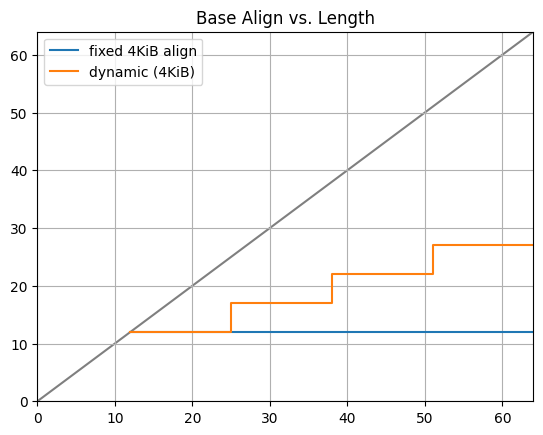

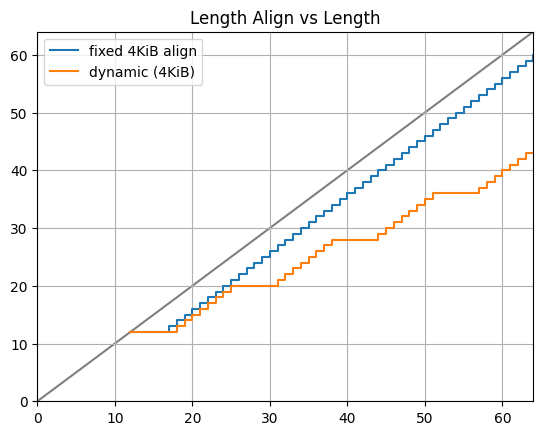

need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)


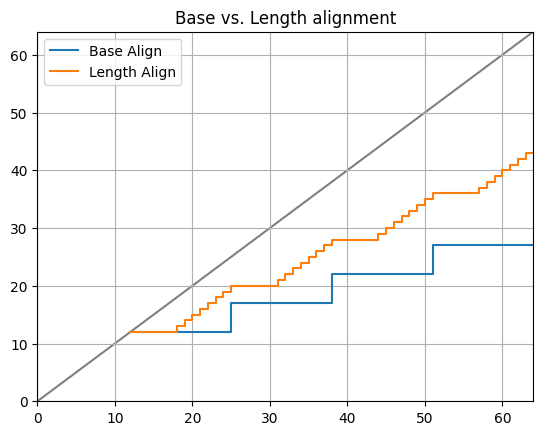

need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)


,length min,length max (excl),base align,length align
0,4.0KiB,256.0KiB,4.0KiB,4.0KiB
1,256.0KiB,512.0KiB,4.0KiB,8.0KiB
2,512.0KiB,1.0MiB,4.0KiB,16.0KiB
3,1.0MiB,2.0MiB,4.0KiB,32.0KiB
4,2.0MiB,4.0MiB,4.0KiB,64.0KiB
5,4.0MiB,8.0MiB,4.0KiB,128.0KiB
6,8.0MiB,16.0MiB,4.0KiB,256.0KiB
7,16.0MiB,32.0MiB,4.0KiB,512.0KiB
8,32.0MiB,2.0GiB,128.0KiB,1.0MiB
9,2.0GiB,4.0GiB,128.0KiB,2.0MiB


In [10]:
# and if 4KiB alignment is really enough...

dynamic_shift_min_align_page = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=5, a_log2=0, b=12),
    exponent_range_to_count={
        (12, 19): 7,   #  0..7  (top 2 bits 00)
        (20, 27): 12,  #  8..15 (top 2 bits 01)
        (28, 35): 17,  # 16..23 (top 2 bits 10)
        (36, 43): 22,  # 24..31 (top 2 bits 11)
    }
)
compare_align_plots([
    ("fixed 4KiB align", array_64addr_base12),
    ("dynamic (4KiB)", dynamic_shift_min_align_page),
])
compare_base_length_align(dynamic_shift_min_align_page)
table_range(dynamic_shift_min_align_page)

need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)
need count = 0x3fffffff to represent length 8589934592.0EiB with exp 63 which can't be represented with LinearEncoding(bit_width=29, a_log2=0, b=0)


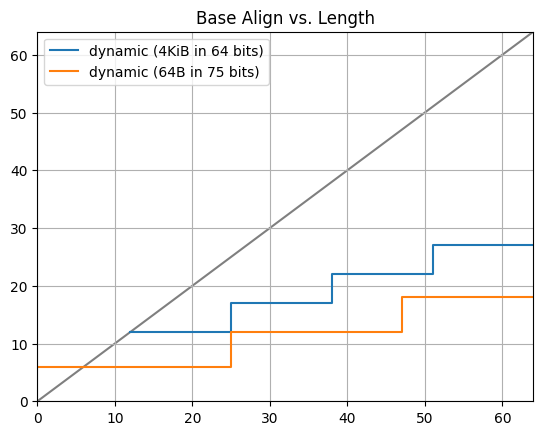

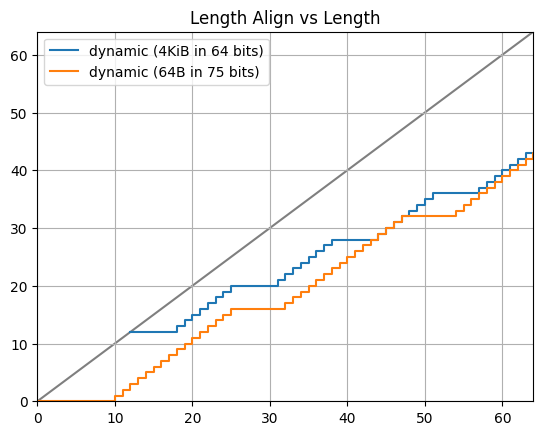

need count = 0x3fffffff to represent length 8589934592.0EiB with exp 63 which can't be represented with LinearEncoding(bit_width=29, a_log2=0, b=0)


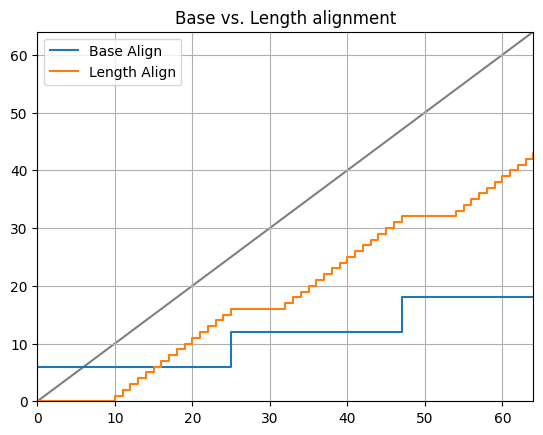

need count = 0x3fffffff to represent length 8589934592.0EiB with exp 63 which can't be represented with LinearEncoding(bit_width=29, a_log2=0, b=0)


,length min,length max (excl),base align,length align
0,1.0B,1.0KiB,64.0B,1.0B
1,1.0KiB,2.0KiB,64.0B,2.0B
2,2.0KiB,4.0KiB,64.0B,4.0B
3,4.0KiB,8.0KiB,64.0B,8.0B
4,8.0KiB,16.0KiB,64.0B,16.0B
...,...,...,...,...
59,67108864.0EiB,134217728.0EiB,16.0MiB,512.0PiB
60,134217728.0EiB,268435456.0EiB,16.0MiB,1.0EiB
61,268435456.0EiB,536870912.0EiB,16.0MiB,2.0EiB
62,536870912.0EiB,1073741824.0EiB,16.0MiB,4.0EiB


In [11]:
# a 64-bit variant for 64-byte alignment
# total bits: 75
#
dynamic_shift_64byte_old_5offset = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=6, a_log2=0, b=6),
    exponent_range_to_count={
        ( 5, 21): 11,  #  0..15 (top 2 bits 00) TODO this is the reason it's worse than the 4KiB.
        (22, 37): 15,  # 16..31 (top 2 bits 01)
        (38, 53): 19,  # 32..47 (top 2 bits 10)
        (54, 69): 23,  # 48..63 (top 2 bits 11)
    },
    total_bit_width=75
)
dynamic_shift_64byte = DynamicRangeShift(
    exponent_enc=LinearEncoding(bit_width=6, a_log2=0, b=0),
    exponent_range_to_count={
        ( 0, 15): 11,  #  0..15 (top 2 bits 00) TODO this is the reason it's worse than cheri...
        (16, 31): 17,  # 16..31 (top 2 bits 01)
        (32, 47): 23,  # 32..47 (top 2 bits 10)
        (48, 63): 29,  # 48..63 (top 2 bits 11)
    },
    total_bit_width=75
)
compare_align_plots([
    ("dynamic (4KiB in 64 bits)", dynamic_shift_min_align_page),
    ("dynamic (64B in 75 bits)", dynamic_shift_64byte),
])
# plot_ranges("64byte", dynamic_shift_64byte)
compare_base_length_align(dynamic_shift_64byte)
table_range(dynamic_shift_64byte)

need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)
need count = 0x3fffffff to represent length 8589934592.0EiB with exp 63 which can't be represented with LinearEncoding(bit_width=29, a_log2=0, b=0)
need count = 0x8000000 to represent length 8.0EiB with exp 37 which can't be represented with LinearEncoding(bit_width=27, a_log2=0, b=0)


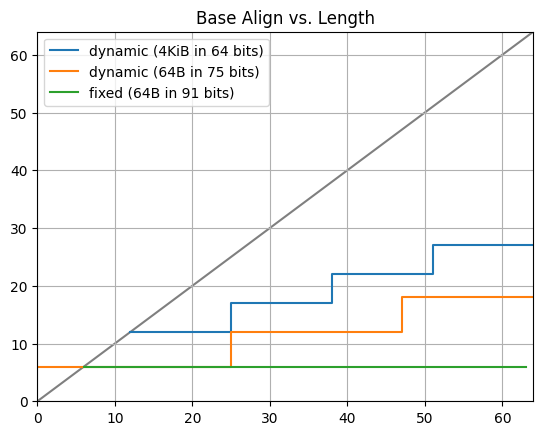

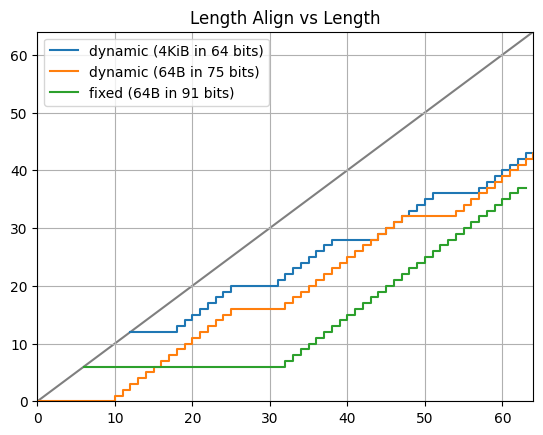

In [12]:
array_64addr_91bit_base6 = ArrayOfElemRangeFormat(addrspace_width=64, base_align=6, exponent_enc=LinearEncoding.offset(bit_width=5, offset=6), count_enc=LinearEncoding.id(27))
# NOTE THIS REQUIRES IMPLICIT TOP
compare_align_plots([
    ("dynamic (4KiB in 64 bits)", dynamic_shift_min_align_page),
    ("dynamic (64B in 75 bits)", dynamic_shift_64byte),
    ("fixed (64B in 91 bits)", array_64addr_91bit_base6),
])

need count = 0x7fffff to represent length 64.0EiB with exp 43 which can't be represented with LinearEncoding(bit_width=22, a_log2=0, b=0)
need count = 0x3fffffff to represent length 8589934592.0EiB with exp 63 which can't be represented with LinearEncoding(bit_width=29, a_log2=0, b=0)
Can't represent exp 64 in 6 bits
Can't represent exp 70 in 6 bits


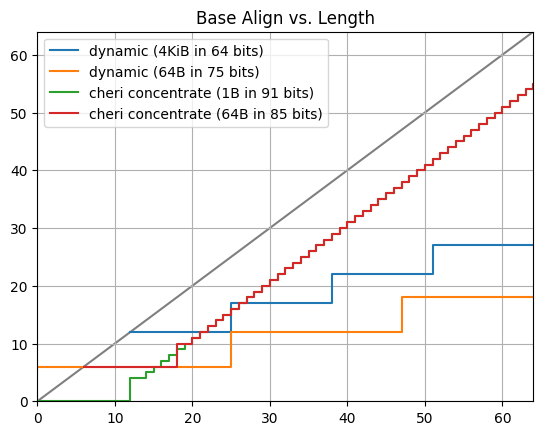

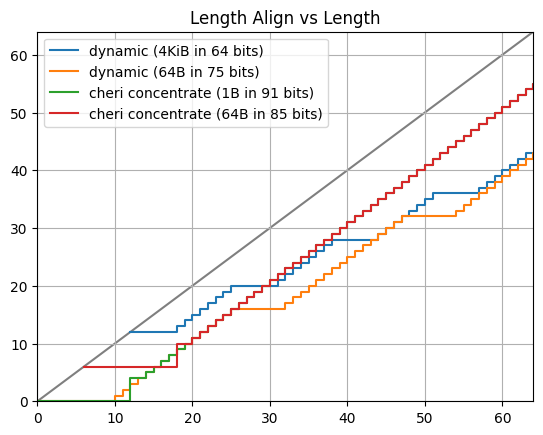

In [17]:
class CheriConcentrate128(RangeFormat):
    min_align: int
    
    addr: LinearEncoding
    b_e: LinearEncoding = LinearEncoding.id(3)
    t_e: LinearEncoding = LinearEncoding.id(3)
    b: LinearEncoding
    t: LinearEncoding

    mw: int

    def __init__(self, mw: int = 14, min_align: int = 0):
        assert mw > 3
        self.addr = LinearEncoding.shifted_left(64 - min_align, shift=min_align)
        # the full value B = {self.b | self.b_e} if internal_exponent else self.b
        self.b = LinearEncoding.shifted_left(mw-3, shift=3)
        # the full value T = {self.t | self.t_e} if internal_exponent else self.t
        # we need two fewer bits from t because we derive them from the relation between a, b, and t
        self.t = LinearEncoding.shifted_left(mw-3 - 2, shift=3)
        # the exponent E = 0 if internal_exponent else {self.t_e | self.b_e}
        self.mw = mw
        self.min_align=min_align
    
    @property
    def addrspace_width(self) -> int:
        return 64
        
    def format_bits(self):
        return [
            self.b_e.as_bits("B_E"),
            Bits("B", (self.b.bit_width-3, 3)),
            self.t_e.as_bits("T_E"),
            Bits("T", (self.t.bit_width-3, 3)),
            Bits("I_E", 1),
            
            # Bits("otype", 18),
            # Bits("?", 3),
            # Bits("p", 16),
        
            self.addr.as_bits("addr"),
        ]

    @property
    def min_length(self) -> int:
        return (2 ** self.min_align)

    def get_stats_for_length(self, length: int) -> Optional[RangeFormatStats]:
        # Figure out if we're in I_E mode or not.
        # If the MSB is smaller than the mantissa width, we can represent the length entirely in the base/top mantissa
        # e.g. if MW=14 the maximum top is all 1s (2^14-1)
        internal_exponent = msb_of(length) <= (self.mw+self.min_align)

        if internal_exponent:
            return RangeFormatStats(
                length_min=2**self.min_align,
                length_max_excl=(2**(self.mw-2+self.min_align)),

                min_base_align_bits=self.min_align,
                min_length_align_bits=self.min_align,
            )
        else:
            # We're using an actual exponent.
            # Choose E such that the msb=mw+E.
            # Bit 0 of top represents 2^(E+min_align).
            # Bit 3 of top (the first settable bit) represents 2^(E+min_align+3)
            # Bit MW-1 of top represents 2^(E+min_align+MW-1)
            # Bit MW of top (implicitly 1) represents 2^(E+min_align+MW)
            exp = msb_of(length) - self.mw # exp = E+min_align
            # representability checks
            if exp < self.min_align:
                return None
            if msb_of(exp-self.min_align) >= 6:
                print(f"Can't represent exp {exp} in 6 bits") 
                return None
            if msb_of(length) - lsb_of(length) > (self.mw - 3):
                # e.g. length = bit MW+E | bit 3+E is the maximum representable precision
                return None

            return RangeFormatStats(
                # Length is (MW-1)-bits long
                # The minimum length we represent with this E is (1 | 0'(MW-2)) << (E+min_align) = 2^(E+min_align+mw-2)?
                length_min=2 ** (exp + self.mw - 2),
                # The maximum length we represent with this E is (1 | 1'(MW-2-3) | 0'3) << (E+min_align) = (2^(mw-1-3) - 1)**2^(E+min_align+3) ~= 2^(mw-1-3+E+min_align+3) = 2^(mw+E+min_align-1)
                length_max_excl=2 ** (exp + self.mw-1),
                
                min_base_align_bits=exp + 3,
                min_length_align_bits=exp + 3,
            )

# as specified in TR-951
cheri_concentrate_128_tr951 = CheriConcentrate128(mw=14)
cheri_concentrate_128_6bit_tr951 = CheriConcentrate128(mw=14, min_align=6)
compare_align_plots([
    ("dynamic (4KiB in 64 bits)", dynamic_shift_min_align_page),
    ("dynamic (64B in 75 bits)", dynamic_shift_64byte),
    # ("fixed (64B in 91 bits)", array_64addr_91bit_base6),
    ("cheri concentrate (1B in 91 bits)", cheri_concentrate_128_tr951),
    ("cheri concentrate (64B in 85 bits)", cheri_concentrate_128_6bit_tr951),
])

In [16]:
# CHERI Concentrate tracks dynamic 64B pretty closely for length align, but is so much worse in base align, despite being bigger.
# They simply have different goals: CHERI needs to store base and top while the address pointer is gallivanting off somewhere, and they have to store the address pointer with full precision so they can't afford bits to store the base at full precision.
# This is because they're forced to store the full address, and they don't have the flexibility to sacrifice parts of the address